In [1]:
# Jupyter Notebook: Risky Location Model for Personal Security Solution (ACLED Tunisia)

# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Note: Tailored for ACLED Tunisia dataset (1997-2025, ~11,367 events).
# Using '../data/tunisia_acled_1997_2025.csv' (~5.7 MB).
# Filtering for ~2,623 high-risk events: Riots (1905), Violence against civilians (184),
# Battles (307), Explosions/Remote violence (227), plus sub-events like Violent demonstration.
# Improvements: Temporal features (month, day_of_week cyclic), event type weights,
# hybrid scoring (density + recency + fatalities), KDE heatmap, enhanced predictions
# (score, distance, event type), temporal weighting (alpha=0.5), noise handling (beta=10),
# dynamic eps, Tunisia map.
# DBSCAN eps=dynamic (0.01-0.1), min_samples=3-5.
# Tunisia's area (~163,610 km²) requires smaller eps vs. Chicago (~606 km²).


In [4]:

# Step 1: Load and preprocess ACLED data
acled_file = '../../data/1900-01-01-2025-06-18-Northern_Africa-Tunisia.csv'

crime_file = '../data/tunisia_street_crime.csv'
current_year = 2025
alpha = 0.5  # Time decay parameter
beta = 5.0  # Noise distance decay parameter #kent 10
event_type_weights = {
    'Battles': 2.0,
    'Violence against civilians': 3.0,
    'Explosions/Remote violence': 1.2,
    'Riots': 0.5,
    'Protests': 0.5,
    'Street Crime': 3.0
}

# Optimize data types
dtypes = {
    'latitude': 'float32',
    'longitude': 'float32',
    'event_type': 'category',
    'sub_event_type': 'category',
    'disorder_type': 'category',
    'civilian_targeting': 'category',
    'fatalities': 'int32',
    'event_date': 'object',
    'year': 'int32',
    'admin1': 'category',
    'location': 'category'
}

In [5]:


try:
    if os.path.exists(acled_file):
        print(f"Loading ACLED Tunisia Data from {acled_file}")
        df = pd.read_csv(acled_file, dtype=dtypes, usecols=[
            'latitude', 'longitude', 'event_type', 'sub_event_type', 'disorder_type',
            'civilian_targeting', 'fatalities', 'event_date', 'year', 'admin1', 'location'
        ])
        print("Columns in CSV:", df.columns.tolist())
        print("Total events:", len(df))
    else:
        print(f"No ACLED data found at {acled_file}.")
        print("Download from https://acleddata.com/data-export-tool/")
        raise FileNotFoundError("ACLED data missing")

    # Check required columns
    required_cols = ['latitude', 'longitude', 'event_type', 'sub_event_type', 'fatalities', 'year', 'event_date']
    available_cols = df.columns.tolist()
    missing_cols = [col for col in required_cols if col not in available_cols]
    if missing_cols:
        print(f"Error: Missing columns {missing_cols}. Available columns: {available_cols}")
        raise ValueError("Missing required columns")

    # Load street crime data if available
    if os.path.exists(crime_file):
        crime_df = pd.read_csv(crime_file, dtype={'latitude': 'float32', 'longitude': 'float32'})
        crime_df['event_type'] = 'Street Crime'
        crime_df['sub_event_type'] = 'Assault/Robbery'
        crime_df['fatalities'] = 0
        crime_df['year'] = 2025
        crime_df['event_date'] = '01/01/2025'
        crime_df['admin1'] = 'Unknown'
        df = pd.concat([df, crime_df], ignore_index=True)
        print("Added street crime data:", crime_df.shape)

except MemoryError:
    print("MemoryError: Insufficient RAM. Try closing other applications or running on Google Colab.")
    raise
except Exception as e:
    print(f"Error loading data: {e}. Ensure '../data/tunisia_acled_1997_2025.csv' exists.")
    raise


Loading ACLED Tunisia Data from ../../data/1900-01-01-2025-06-18-Northern_Africa-Tunisia.csv
Columns in CSV: ['event_date', 'year', 'disorder_type', 'event_type', 'sub_event_type', 'civilian_targeting', 'admin1', 'location', 'latitude', 'longitude', 'fatalities']
Total events: 11367


In [6]:

# Drop rows with missing coordinates
df = df.dropna(subset=['latitude', 'longitude'])
print("Shape after dropping missing coordinates:", df.shape)


Shape after dropping missing coordinates: (11367, 11)


In [7]:

# Parse event_date and extract temporal features
df['event_date'] = pd.to_datetime(df['event_date'], format='%d %B %Y', errors='coerce')
df['month'] = df['event_date'].dt.month
df['day_of_week'] = df['event_date'].dt.dayofweek
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
print("Temporal features added:\n", df[['month', 'month_sin', 'month_cos', 'day_of_week', 'day_of_week_sin', 'day_of_week_cos']].head())


Temporal features added:
    month     month_sin  month_cos  day_of_week  day_of_week_sin  \
0      6  1.224647e-16       -1.0            0         0.000000   
1      6  1.224647e-16       -1.0            0         0.000000   
2      6  1.224647e-16       -1.0            0         0.000000   
3      6  1.224647e-16       -1.0            1         0.781831   
4      6  1.224647e-16       -1.0            1         0.781831   

   day_of_week_cos  
0          1.00000  
1          1.00000  
2          1.00000  
3          0.62349  
4          0.62349  


In [8]:

# Add temporal and event type weights
df['temporal_weight'] = np.exp(-alpha * (current_year - df['year']))
df['event_type_weight'] = df['event_type'].map(event_type_weights).fillna(0.5)
df['severity_weight'] = df['temporal_weight'] * df['event_type_weight']
print("Weight distributions:\n", df[['temporal_weight', 'event_type_weight', 'severity_weight']].describe())


Weight distributions:
        temporal_weight  event_type_weight  severity_weight
count     1.136700e+04       11367.000000     1.136700e+04
mean      1.338166e-01           0.594959     7.012487e-02
std       1.966624e-01           0.403386     1.087559e-01
min       8.315287e-07           0.500000     4.157644e-07
25%       1.831564e-02           0.500000     9.157819e-03
50%       4.978707e-02           0.500000     3.663128e-02
75%       1.353353e-01           0.500000     6.766764e-02
max       1.000000e+00           3.000000     3.000000e+00


In [9]:

# Filter for high-risk events (post-2011)
high_risk_events = ['Violence against civilians', 'Riots', 'Battles', 'Explosions/Remote violence']
high_risk_sub_events = ['Violent demonstration', 'Mob violence', 'Attack', 'Remote explosive/landmine/IED', 'Excessive force against protesters']


df = df[(df['year'] >= 2011) & (
    df['event_type'].isin(high_risk_events) |
    df['sub_event_type'].isin(high_risk_sub_events) |
    df['civilian_targeting'].notna() |
    (df['fatalities'] > 0) |
    ((df['event_type'] == 'Protests') & (df['sub_event_type'] == 'Violent demonstration'))
)]
print("Shape after filtering high-risk events (year>=2011):", df.shape)
print("Event types:\n", df['event_type'].value_counts())
print("Sub-event types:\n", df['sub_event_type'].value_counts())
print("Fatalities distribution:\n", df['fatalities'].value_counts())


Shape after filtering high-risk events (year>=2011): (2620, 20)
Event types:
 event_type
Riots                         1881
Battles                        305
Explosions/Remote violence     225
Violence against civilians     174
Protests                        33
Strategic developments           2
Name: count, dtype: int64
Sub-event types:
 sub_event_type
Violent demonstration                 1640
Armed clash                            305
Mob violence                           241
Attack                                 163
Remote explosive/landmine/IED          161
Excessive force against protesters      33
Shelling/artillery/missile attack       32
Air/drone strike                        28
Abduction/forced disappearance          11
Suicide bomb                             4
Disrupted weapons use                    2
Headquarters or base established         0
Agreement                                0
Non-violent transfer of territory        0
Other                                   

In [10]:

# Check if data is sufficient
if df.shape[0] < 1000:
    print("Warning: Only", df.shape[0], "high-risk events found. Adding synthetic data for Tunis.")
    synthetic = pd.DataFrame({
        'latitude': np.random.normal(36.8065, 0.02, 300),
        'longitude': np.random.normal(10.1815, 0.02, 300),
        'event_type': 'Violence against civilians',
        'sub_event_type': 'Attack',
        'fatalities': np.random.randint(0, 2, 300),
        'event_date': pd.to_datetime('01/01/2025'),
        'year': 2025,
        'admin1': 'Tunis',
        'temporal_weight': 1.0,
        'event_type_weight': event_type_weights['Violence against civilians'],
        'severity_weight': 1.0 * event_type_weights['Violence against civilians'],
        'month': 1,
        'day_of_week': 0,
        'month_sin': np.sin(2 * np.pi * 1 / 12),
        'month_cos': np.cos(2 * np.pi * 1 / 12),
        'day_of_week_sin': np.sin(2 * np.pi * 0 / 7),
        'day_of_week_cos': np.cos(2 * np.pi * 0 / 7)
    })
    df = pd.concat([df, synthetic], ignore_index=True)
    print("Added 300 synthetic events for Tunis")
    print("New shape:", df.shape)


In [11]:
# Downsample Riots to balance event types
#<=> Filter only "Riots" and randomly select 500 of them
riots = df[df['event_type'] == 'Riots'].sample(n=400, random_state=42)
non_riots = df[df['event_type'] != 'Riots']
df = pd.concat([riots, non_riots], ignore_index=True)
print("Shape after downsampling Riots:", df.shape)

Shape after downsampling Riots: (1139, 20)


In [12]:
# adds urban context to the dataset by checking whether each event occurred inside a residential area in Tunisia, using OpenStreetMap (OSM) and adds a new column 'in_residential' to indicate this
!pip install osmnx
import osmnx as ox
from shapely.geometry import Point
try:
    print("Fetching OSM residential areas for Tunisia...")
    gdf = ox.features_from_place('Tunisia', tags={'landuse': 'residential'})
    print("OSM residential areas shape:", gdf.shape)
    from shapely.geometry import Point
    df['in_residential'] = df.apply(
        lambda x: any(gdf['geometry'].contains(Point(x['longitude'], x['latitude']))), axis=1
    )
    df['severity_weight'] *= df['in_residential'].apply(lambda x: 1.5 if x else 1.0)
    print("Updated severity_weight for urban areas:\n", df['severity_weight'].describe())
except Exception as e:
    print(f"Error fetching OSM data: {e}. Proceeding without urban context.")
    df['in_residential'] = False


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Fetching OSM residential areas for Tunisia...
OSM residential areas shape: (5676, 111)
Updated severity_weight for urban areas:
 count    1139.000000
mean        0.072992
std         0.196166
min         0.000456
25%         0.006765
50%         0.020214
75%         0.061564
max         3.000000
Name: severity_weight, dtype: float64


In [13]:

# Extract features
X = df[['latitude', 'longitude']].values
print("Coordinate ranges - Latitude: [{:.4f}, {:.4f}]".format(df['latitude'].min(), df['latitude'].max()))
print("Coordinate ranges - Longitude: [{:.4f}, {:.4f}]".format(df['longitude'].min(), df['longitude'].max()))


Coordinate ranges - Latitude: [30.2500, 37.2744]
Coordinate ranges - Longitude: [7.6557, 11.5538]


In [14]:

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled data shape:", X_scaled.shape)


Scaled data shape: (1139, 2)


Estimated eps from k-distance plot: 0.2319


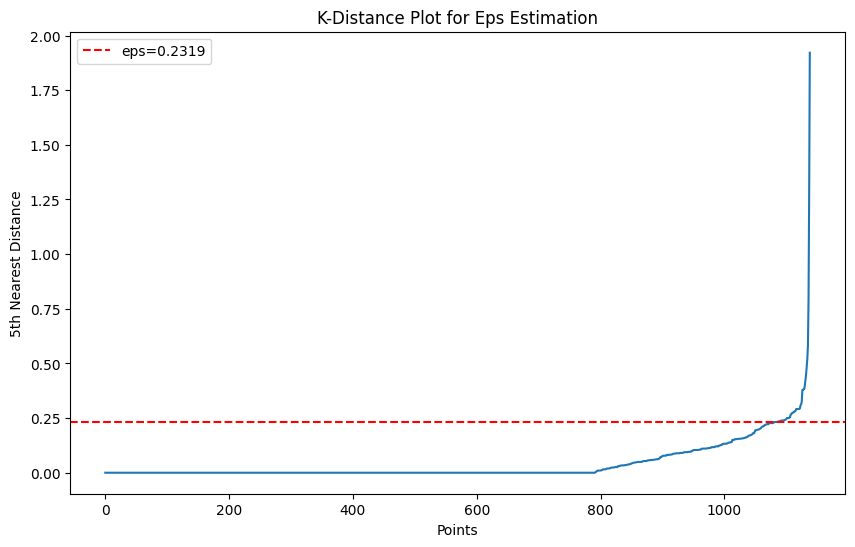

In [15]:

# Plot k-distance to estimate eps
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_scaled)
distances, _ = neigh.kneighbors(X_scaled)
distances = np.sort(distances[:, 4])
eps_estimate = np.percentile(distances, 95)
print(f"Estimated eps from k-distance plot: {eps_estimate:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('5th Nearest Distance')
plt.title('K-Distance Plot for Eps Estimation')
plt.axhline(y=eps_estimate, color='r', linestyle='--', label=f'eps={eps_estimate:.4f}')
plt.legend()
plt.show()


In [16]:

# Step 2: Apply DBSCAN clustering
#Retry with eps=0.15 or eps=0.05
eps = max(0.01, min(0.1, eps_estimate))
esp=0.1

min_samples = 5 # Minimum samples for core points #retest 3 
min_samples=3
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
clusters = dbscan.fit_predict(X_scaled)
df['Cluster'] = clusters

# Debug clustering
print("Cluster counts:\n", df['Cluster'].value_counts())
noise_ratio = (df['Cluster'] == -1).mean()
if noise_ratio > 0.5:
    print(f"Warning: {noise_ratio:.2%} points are noise. Increasing eps to {eps * 1.5:.4f}.")
    eps *= 1.5
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    clusters = dbscan.fit_predict(X_scaled)
    df['Cluster'] = clusters
    print("New cluster counts:\n", df['Cluster'].value_counts())
if (df['Cluster'] == -1).all():
    print("Warning: All points are noise. Trying min_samples=3.")
    min_samples = 3
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    clusters = dbscan.fit_predict(X_scaled)
    df['Cluster'] = clusters
    print("New cluster counts:\n", df['Cluster'].value_counts())


Cluster counts:
 Cluster
 6     173
 2     162
-1     105
 62     71
 47     50
      ... 
 60      3
 36      3
 46      3
 66      3
 67      3
Name: count, Length: 69, dtype: int64


In [17]:

# Compute dominant event type per cluster
cluster_event_types = df[df['Cluster'] != -1].groupby('Cluster')['event_type'].agg(lambda x: x.mode()[0])
print("Dominant event types per cluster:\n", cluster_event_types)


Dominant event types per cluster:
 Cluster
0                          Riots
1                          Riots
2     Explosions/Remote violence
3                          Riots
4                        Battles
                 ...            
63    Explosions/Remote violence
64    Explosions/Remote violence
65                       Battles
66    Explosions/Remote violence
67                       Battles
Name: event_type, Length: 68, dtype: category
Categories (6, object): ['Battles', 'Explosions/Remote violence', 'Protests', 'Riots', 'Strategic developments', 'Violence against civilians']


In [18]:

# Step 3: Assign risk scores
cluster_weights = df[df['Cluster'] != -1].groupby('Cluster')['severity_weight'].sum()
cluster_fatalities = df[df['Cluster'] != -1].groupby('Cluster')['fatalities'].sum()
print("Cluster weights (non-noise):\n", cluster_weights)
print("Cluster fatalities (non-noise):\n", cluster_fatalities)
if cluster_weights.empty:
    print("Warning: No clusters formed. Setting Risk_Score to 0.0.")
    df['Risk_Score'] = 0.0
else:
    df['Risk_Score'] = df['Cluster'].map(cluster_weights).fillna(0) / cluster_weights.max()
    df['Risk_Score'] = df.apply(
        lambda x: x['Risk_Score'] * (1 + 0.1 * cluster_fatalities.get(x['Cluster'], 0)) if x['Cluster'] != -1 else 0,
        axis=1
    )
    # Ensure small clusters with severe events have minimum score
    df['Risk_Score'] = df.apply(
        lambda x: max(x['Risk_Score'], 0.1 * cluster_fatalities.get(x['Cluster'], 0) / cluster_fatalities.max()) if x['Cluster'] != -1 else x['Risk_Score'],
        axis=1
    )
    df['Risk_Score'] = df['Risk_Score'] / df['Risk_Score'].max()
print("Risk score distribution:\n", df['Risk_Score'].describe())


Cluster weights (non-noise):
 Cluster
0      0.067726
1      3.415346
2     13.991414
3      0.727303
4      0.127122
        ...    
63     0.723020
64     0.699465
65     0.383926
66     0.163066
67     0.095944
Name: severity_weight, Length: 68, dtype: float64
Cluster fatalities (non-noise):
 Cluster
0       4
1       4
2     149
3       4
4       5
     ... 
63      0
64      8
65      2
66      5
67      2
Name: fatalities, Length: 68, dtype: int32
Risk score distribution:
 count    1139.000000
mean        0.261000
std         0.376803
min         0.000000
25%         0.002281
50%         0.015644
75%         0.659745
max         1.000000
Name: Risk_Score, dtype: float64


In [19]:

# Step 4: KDE heatmap
kde = gaussian_kde([df['longitude'], df['latitude']], weights=df['severity_weight'])
x_grid, y_grid = np.meshgrid(
    np.linspace(df['longitude'].min(), df['longitude'].max(), 100),
    np.linspace(df['latitude'].min(), df['latitude'].max(), 100)
)
z = kde([x_grid.ravel(), y_grid.ravel()]).reshape(x_grid.shape)
z = z / z.max()  # Normalize



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


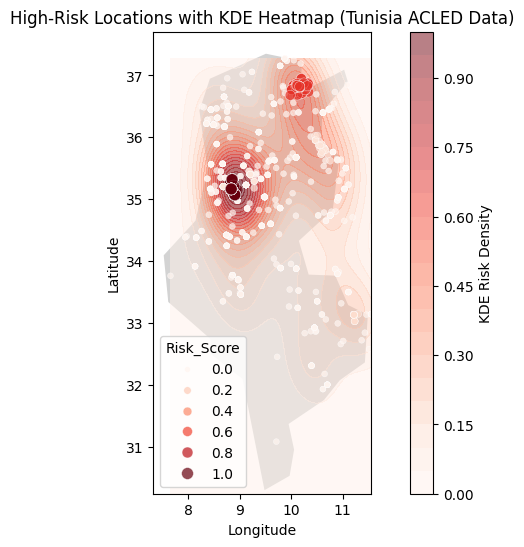

In [23]:
#Visualize KDE and clusters
!pip install geodatasets
import geodatasets
import geodatasets
import geopandas as gpd

world = gpd.read_file("../../data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
tunisia = world[world['NAME'] == 'Tunisia']

fig, ax = plt.subplots(figsize=(10, 6))
tunisia.plot(ax=ax, color='lightgrey')
plt.contourf(x_grid, y_grid, z, levels=20, cmap='Reds', alpha=0.5)
sns.scatterplot(data=df, x='longitude', y='latitude', hue='Risk_Score', size='Risk_Score', palette='Reds', ax=ax, alpha=0.7)
plt.title('High-Risk Locations with KDE Heatmap (Tunisia ACLED Data)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='KDE Risk Density')
plt.show()


In [24]:
#neww
!pip install folium
import folium
from folium.plugins import MarkerCluster

# Create base map centered on Tunisia
m = folium.Map(location=[34.0, 9.0], zoom_start=6)

# Add cluster of risky events
marker_cluster = MarkerCluster().add_to(m)

for idx, row in df.iterrows():
    popup_text = f"Type: {row['event_type']}<br>Score: {row['Risk_Score']:.2f}<br>Cluster: {row['Cluster']}"
    color = 'red' if row['Risk_Score'] > 0.6 else 'orange' if row['Risk_Score'] > 0.3 else 'blue'
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=5,
        popup=popup_text,
        color=color,
        fill=True,
        fill_opacity=0.7
    ).add_to(marker_cluster)

m.save("risk_map_tunisia.html")



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
# Step 5: Predict risk score
def predict_risk_score_dbscan(lat, lon, model, scaler, cluster_weights, cluster_fatalities, cluster_event_types, df, beta=beta):
    X_new = np.array([[lat, lon]], dtype=np.float32)
    X_new_scaled = scaler.transform(X_new)
    if len(model.components_) == 0:
        print("No core points in model. Increase eps/min_samples or add more data.")
        return (0.0, 0.0, 'None')
    distances = np.sqrt(((X_new_scaled - model.components_)**2).sum(axis=1))
    nearest_idx = np.argmin(distances)
    max_distance = np.sqrt(((X_scaled - X_scaled.mean(axis=0))**2).sum(axis=1)).max()
    #max_distance = np.max(np.sqrt(((X_scaled - model.components_)**2).sum(axis=1)))
    normalized_distance = distances[nearest_idx] / max_distance
    nearest_cluster = model.labels_[model.core_sample_indices_[nearest_idx]]
    event_type = cluster_event_types.get(nearest_cluster, 'Unknown')
    if distances[nearest_idx] <= model.eps:
        score = cluster_weights.get(nearest_cluster, 0) / (cluster_weights.max() if not cluster_weights.empty else 1)
        score *= (1 + 0.1 * cluster_fatalities.get(nearest_cluster, 0))
        score /= (cluster_weights / cluster_weights.max() * (1 + 0.1 * cluster_fatalities)).max()
        print(f"Assigned to cluster {nearest_cluster} (type: {event_type}) with score {score:.2f}, normalized distance {normalized_distance:.2f}")
    else:
        base_score = cluster_weights.get(nearest_cluster, 0) / (cluster_weights.max() if not cluster_weights.empty else 1)
        base_score *= (1 + 0.1 * cluster_fatalities.get(nearest_cluster, 0))
        #score = base_score * np.exp(-beta * (distances[nearest_idx] - model.eps))
        score = max(base_score * np.exp(-beta * (distances[nearest_idx] - model.eps)), 0.1 * base_score)
        score /= (cluster_weights / cluster_weights.max() * (1 + 0.1 * cluster_fatalities)).max()
        print(f"Noise point near cluster {nearest_cluster} (type: {event_type}, distance {distances[nearest_idx]:.2f} > eps {model.eps}), score {score:.2f}, normalized distance {normalized_distance:.2f}")
    return (score, normalized_distance, event_type)


In [26]:
# Example predictions (Tunisia coordinates)
test_points = [
    (36.8065, 10.1815),  # Tunis
    (33.8815, 10.0982),  # Gabes
    (35.6754, 10.1033)   # Kairouan
]
for lat, lon in test_points:
    score, norm_dist, event_type = predict_risk_score_dbscan(lat, lon, dbscan, scaler, cluster_weights, cluster_fatalities, cluster_event_types, df)
    print(f'Risk Score for ({lat}, {lon}): {score:.2f}, Norm. Distance: {norm_dist:.2f}, Nearest Cluster Type: {event_type}')



Assigned to cluster 6 (type: Riots) with score 0.66, normalized distance 0.00
Risk Score for (36.8065, 10.1815): 0.66, Norm. Distance: 0.00, Nearest Cluster Type: Riots
Assigned to cluster 38 (type: Riots) with score 0.00, normalized distance 0.00
Risk Score for (33.8815, 10.0982): 0.00, Norm. Distance: 0.00, Nearest Cluster Type: Riots
Assigned to cluster 1 (type: Riots) with score 0.02, normalized distance 0.00
Risk Score for (35.6754, 10.1033): 0.02, Norm. Distance: 0.00, Nearest Cluster Type: Riots


In [27]:
# Step 3: Assign risk scores for DBSCAN
clusters_dbscan = dbscan.fit_predict(X_scaled)
df['Cluster_DBSCAN'] = clusters_dbscan
cluster_weights_dbscan = df[df['Cluster_DBSCAN'] != -1].groupby('Cluster_DBSCAN')['severity_weight'].sum()
cluster_fatalities_dbscan = df[df['Cluster_DBSCAN'] != -1].groupby('Cluster_DBSCAN')['fatalities'].sum()
if cluster_weights_dbscan.empty:
    print("Warning: No DBSCAN clusters formed. Setting Risk_Score to 0.0.")
    df['Risk_Score_DBSCAN'] = 0.0
else:
    df['Risk_Score_DBSCAN'] = df['Cluster_DBSCAN'].map(cluster_weights_dbscan).fillna(0) / cluster_weights_dbscan.max()
    df['Risk_Score_DBSCAN'] = df.apply(
        lambda x: x['Risk_Score_DBSCAN'] * (1 + 0.2 * cluster_fatalities_dbscan.get(x['Cluster_DBSCAN'], 0)) if x['Cluster_DBSCAN'] != -1 else 0,
        axis=1
    )
    df['Risk_Score_DBSCAN'] = df.apply(
        lambda x: max(x['Risk_Score_DBSCAN'], 0.1 * cluster_fatalities_dbscan.get(x['Cluster_DBSCAN'], 0) / cluster_fatalities_dbscan.max()) if x['Cluster_DBSCAN'] != -1 else x['Risk_Score_DBSCAN'],
        axis=1
    )
    df['Risk_Score_DBSCAN'] = df['Risk_Score_DBSCAN'] / df['Risk_Score_DBSCAN'].max()
print("DBSCAN Risk score distribution:\n", df['Risk_Score_DBSCAN'].describe())

DBSCAN Risk score distribution:
 count    1139.000000
mean        0.258739
std         0.377205
min         0.000000
25%         0.001421
50%         0.012114
75%         0.656305
max         1.000000
Name: Risk_Score_DBSCAN, dtype: float64


In [ ]:

# Step 6: Save model
import joblib
joblib.dump(dbscan, '../../models/riskyzones/risky_location_model_dbscan.pkl') #trained DBSCAN clustering model.It contains the core samples, eps value, labels, etc.
joblib.dump(scaler, '../../models/riskyzones/scaler__risky_loc.pkl') #itted StandardScaler, which was used to scale the latitude/longitude before clustering.

FileNotFoundError: [Errno 2] No such file or directory: '../models/riskyzones/risky_location_model_dbscan.pkl'

In [29]:
from sklearn.cluster import OPTICS

# Step: Refit OPTICS using the scaled data
min_samples = 5
xi = 0.05
model_optics = OPTICS(min_samples=min_samples, xi=xi, metric='euclidean')
model_optics.fit(X_scaled)  # Fit OPTICS on scaled coordinates

# Assign OPTICS clusters
clusters_optics = model_optics.labels_
df['Cluster_OPTICS'] = clusters_optics

# Debug OPTICS clustering
print("OPTICS Cluster counts:\n", df['Cluster_OPTICS'].value_counts())

# Retry with higher xi if too much noise
noise_ratio = (df['Cluster_OPTICS'] == -1).mean()
if noise_ratio > 0.5:
    print(f"High noise ratio ({noise_ratio:.2%}), refitting with xi=0.1")
    xi = 0.1
    model_optics = OPTICS(min_samples=min_samples, xi=xi, metric='euclidean')
    model_optics.fit(X_scaled)
    clusters_optics = model_optics.labels_
    df['Cluster_OPTICS'] = clusters_optics
    print("New OPTICS cluster counts:\n", df['Cluster_OPTICS'].value_counts())

# Compute OPTICS cluster metadata
cluster_event_types_optics = df[df['Cluster_OPTICS'] != -1].groupby('Cluster_OPTICS')['event_type'].agg(lambda x: x.mode()[0] if not x.empty else 'Unknown')
cluster_weights_optics = df[df['Cluster_OPTICS'] != -1].groupby('Cluster_OPTICS')['severity_weight'].sum()
cluster_fatalities_optics = df[df['Cluster_OPTICS'] != -1].groupby('Cluster_OPTICS')['fatalities'].sum()

print("OPTICS dominant event types:\n", cluster_event_types_optics)

OPTICS Cluster counts:
 Cluster_OPTICS
-1     130
 40     79
 23     71
 19     65
 20     58
      ... 
 24      5
 4       5
 41      5
 17      5
 63      5
Name: count, Length: 68, dtype: int64
OPTICS dominant event types:
 Cluster_OPTICS
0     Battles
1     Battles
2       Riots
3       Riots
4     Battles
       ...   
62      Riots
63      Riots
64    Battles
65      Riots
66      Riots
Name: event_type, Length: 67, dtype: category
Categories (6, object): ['Battles', 'Explosions/Remote violence', 'Protests', 'Riots', 'Strategic developments', 'Violence against civilians']


In [30]:
# Assign risk scores for OPTICS
if cluster_weights_optics.empty:
    print("Warning: No OPTICS clusters formed. Setting Risk_Score to 0.0.")
    df['Risk_Score_OPTICS'] = 0.0
else:
    df['Risk_Score_OPTICS'] = df['Cluster_OPTICS'].map(cluster_weights_optics).fillna(0) / cluster_weights_optics.max()
    df['Risk_Score_OPTICS'] = df.apply(
        lambda x: x['Risk_Score_OPTICS'] * (1 + 0.2 * cluster_fatalities_optics.get(x['Cluster_OPTICS'], 0)) if x['Cluster_OPTICS'] != -1 else 0,
        axis=1
    )
    df['Risk_Score_OPTICS'] = df.apply(
        lambda x: max(x['Risk_Score_OPTICS'], 0.1 * cluster_fatalities_optics.get(x['Cluster_OPTICS'], 0) / cluster_fatalities_optics.max()) if x['Cluster_OPTICS'] != -1 else x['Risk_Score_OPTICS'],
        axis=1
    )
    df['Risk_Score_OPTICS'] = df['Risk_Score_OPTICS'] / df['Risk_Score_OPTICS'].max()

print("OPTICS Risk score distribution:\n", df['Risk_Score_OPTICS'].describe())

OPTICS Risk score distribution:
 count    1139.000000
mean        0.204317
std         0.290445
min         0.000000
25%         0.007197
50%         0.027478
75%         0.456281
max         1.000000
Name: Risk_Score_OPTICS, dtype: float64


In [35]:
joblib.dump(model_optics, '../../models/riskyzones/risky_location_model_optics.pkl')


['../../models/riskyzones/risky_location_model_optics.pkl']

In [36]:
def predict_risk_score_optics(lat, lon, model, scaler, cluster_weights, cluster_fatalities, cluster_event_types, X_scaled, beta=5.0):
    X_new = np.array([[lat, lon]], dtype=np.float32)
    X_new_scaled = scaler.transform(X_new)

    # Use core samples from OPTICS
    core_indices = np.where(model.core_distances_ != np.inf)[0]
    if len(core_indices) == 0:
        print("No core points in OPTICS model.")
        return (0.0, 0.0, 'None')  # Fixed syntax error here

    core_points = X_scaled[core_indices]
    labels = model.labels_[core_indices]

    # Compute distances to core points
    distances = np.sqrt(((X_new_scaled - core_points) ** 2).sum(axis=1))
    nearest_idx = np.argmin(distances)
    max_distance = np.sqrt(((X_scaled - X_scaled.mean(axis=0)) ** 2).sum(axis=1)).max()
    normalized_distance = distances[nearest_idx] / max_distance
    nearest_cluster = labels[nearest_idx]

    event_type = cluster_event_types.get(nearest_cluster, 'Unknown')

    # Estimate eps from reachability distances
    eps = np.percentile(model.core_distances_[core_indices], 95) if len(core_indices) > 0 else 0.05

    if distances[nearest_idx] <= eps:
        score = cluster_weights.get(nearest_cluster, 0) / (cluster_weights.max() if not cluster_weights.empty else 1)
        score *= (1 + 0.1 * cluster_fatalities.get(nearest_cluster, 0))
        score /= (cluster_weights / cluster_weights.max() * (1 + 0.1 * cluster_fatalities)).max()
        print(f"Assigned to OPTICS cluster {nearest_cluster} (type: {event_type}) with score {score:.2f}, normalized distance {normalized_distance:.2f}")
    else:
        base_score = cluster_weights.get(nearest_cluster, 0) / (cluster_weights.max() if not cluster_weights.empty else 1)
        base_score *= (1 + 0.1 * cluster_fatalities.get(nearest_cluster, 0))
        score = max(base_score * np.exp(-beta * (distances[nearest_idx] - eps)), 0.1 * base_score)
        score /= (cluster_weights / cluster_weights.max() * (1 + 0.1 * cluster_fatalities)).max()
        print(f"Noise point near OPTICS cluster {nearest_cluster} (type: {event_type}, distance {distances[nearest_idx]:.2f} > eps {eps}), score {score:.2f}, normalized distance {normalized_distance:.2f}")
    
    return (score, normalized_distance, event_type)

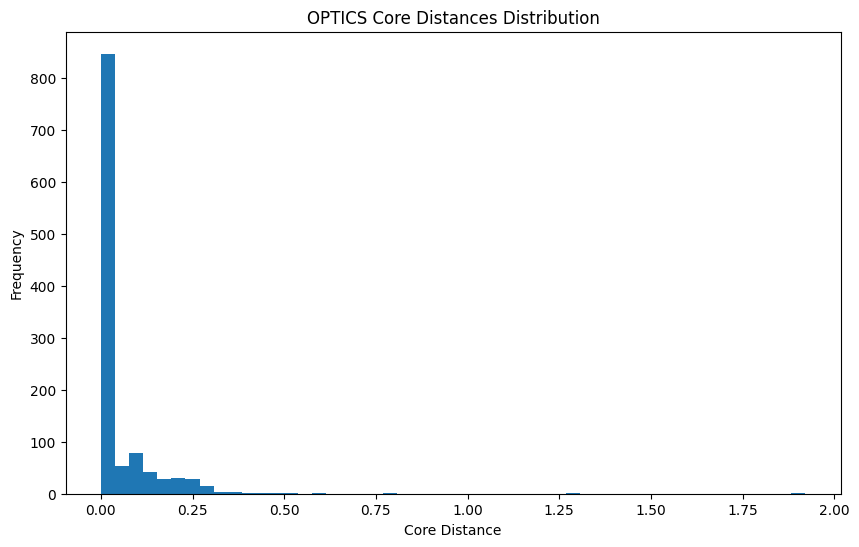

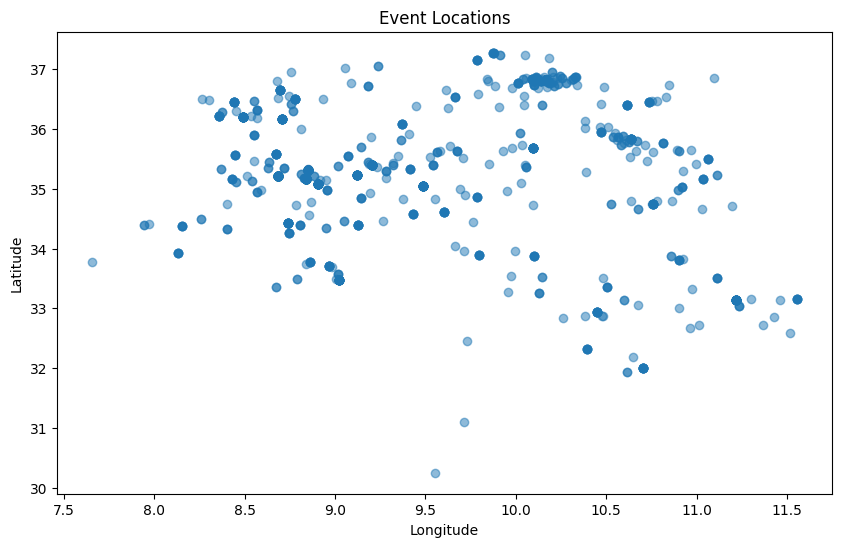

In [37]:
plt.figure(figsize=(10, 6))
plt.hist(model_optics.core_distances_[model_optics.core_distances_ != np.inf], bins=50)
plt.title('OPTICS Core Distances Distribution')
plt.xlabel('Core Distance')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(df['longitude'], df['latitude'], alpha=0.5)
plt.title('Event Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [38]:
# Test predictions
test_points = [
    (36.8065, 10.1815),  # Tunis
    (33.8815, 10.0982),  # Gabes
    (35.6754, 10.1033)   # Kairouan
]
for lat, lon in test_points:
    score_op, dist_op, type_op = predict_risk_score_optics(
        lat, lon, model_optics, scaler, cluster_weights_optics,
        cluster_fatalities_optics, cluster_event_types_optics, X_scaled
    )
    print(f"OPTICS - Risk Score for ({lat}, {lon}): {score_op:.2f}, Norm. Distance: {dist_op:.2f}, Type: {type_op}")

Assigned to OPTICS cluster 39 (type: Riots) with score 0.02, normalized distance 0.00
OPTICS - Risk Score for (36.8065, 10.1815): 0.02, Norm. Distance: 0.00, Type: Riots
Assigned to OPTICS cluster 9 (type: Riots) with score 0.02, normalized distance 0.00
OPTICS - Risk Score for (33.8815, 10.0982): 0.02, Norm. Distance: 0.00, Type: Riots
Assigned to OPTICS cluster 32 (type: Riots) with score 0.14, normalized distance 0.00
OPTICS - Risk Score for (35.6754, 10.1033): 0.14, Norm. Distance: 0.00, Type: Riots


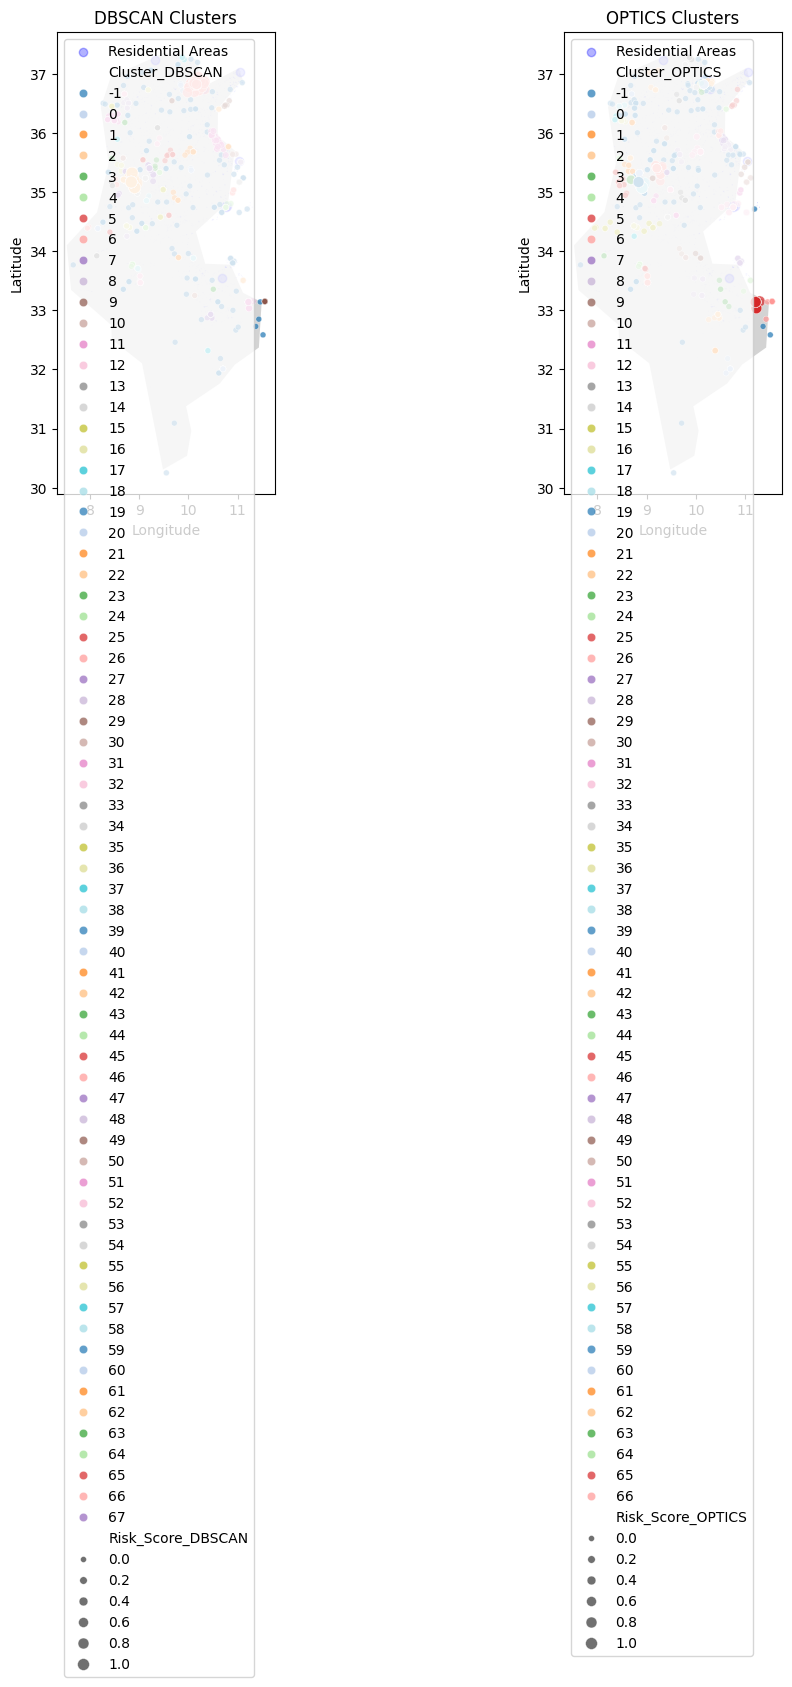

In [39]:
# Compare clusters visually
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
tunisia.plot(ax=ax1, color='lightgrey')
tunisia.plot(ax=ax2, color='lightgrey')
if 'gdf' in locals():
    gdf.plot(ax=ax1, color='blue', alpha=0.3, label='Residential Areas')
    gdf.plot(ax=ax2, color='blue', alpha=0.3, label='Residential Areas')
sns.scatterplot(data=df, x='longitude', y='latitude', hue='Cluster_DBSCAN', size='Risk_Score_DBSCAN', palette='tab20', ax=ax1, alpha=0.7)
sns.scatterplot(data=df, x='longitude', y='latitude', hue='Cluster_OPTICS', size='Risk_Score_OPTICS', palette='tab20', ax=ax2, alpha=0.7)
ax1.set_title('DBSCAN Clusters')
ax2.set_title('OPTICS Clusters')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.legend()
plt.show()

In [40]:
def predict_risk(lat, lon, method='dbscan'):
    if method == 'dbscan':
        return predict_risk_score_dbscan(
            lat, lon, dbscan, scaler,
            cluster_weights_dbscan, cluster_fatalities_dbscan,
            cluster_event_types, X_scaled
        )
    elif method == 'optics':
        return predict_risk_score_optics(
            lat, lon, model_optics, scaler,
            cluster_weights_optics, cluster_fatalities_optics,
            cluster_event_types_optics, X_scaled
        )
    else:
        raise ValueError("Invalid method. Use 'dbscan' or 'optics'.")

In [41]:
test_points = [
    (36.8065, 10.1815),  # Tunis
    (33.8815, 17.0982),  # Gabes
    (35.6754, 10.1033)   # Kairouan
]
for lat, lon in test_points:
    score_db, dist_db, type_db = predict_risk(lat, lon, method='dbscan')
    score_op, dist_op, type_op = predict_risk(lat, lon, method='optics')
    print(f"DBSCAN - Risk Score for ({lat}, {lon}): {score_db:.2f}, Norm. Distance: {dist_db:.2f}, Type: {type_db}")
    print(f"OPTICS - Risk Score for ({lat}, {lon}): {score_op:.2f}, Norm. Distance: {dist_op:.2f}, Type: {type_op}")


Assigned to cluster 6 (type: Riots) with score 0.66, normalized distance 0.00
Assigned to OPTICS cluster 39 (type: Riots) with score 0.02, normalized distance 0.00
DBSCAN - Risk Score for (36.8065, 10.1815): 0.66, Norm. Distance: 0.00, Type: Riots
OPTICS - Risk Score for (36.8065, 10.1815): 0.02, Norm. Distance: 0.00, Type: Riots
Noise point near cluster 49 (type: Battles, distance 6.62 > eps 0.1), score 0.00, normalized distance 1.52
Noise point near OPTICS cluster 6 (type: Battles, distance 6.62 > eps 0.231865859758318), score 0.00, normalized distance 1.52
DBSCAN - Risk Score for (33.8815, 17.0982): 0.00, Norm. Distance: 1.52, Type: Battles
OPTICS - Risk Score for (33.8815, 17.0982): 0.00, Norm. Distance: 1.52, Type: Battles
Assigned to cluster 1 (type: Riots) with score 0.02, normalized distance 0.00
Assigned to OPTICS cluster 32 (type: Riots) with score 0.14, normalized distance 0.00
DBSCAN - Risk Score for (35.6754, 10.1033): 0.02, Norm. Distance: 0.00, Type: Riots
OPTICS - Risk 

In [42]:
# Save DBSCAN metadata
joblib.dump(cluster_weights_dbscan, '../../models/riskyzones/cluster_weights_dbscan.pkl')
joblib.dump(cluster_fatalities_dbscan, '../../models/riskyzones/cluster_fatalities_dbscan.pkl')
joblib.dump(cluster_event_types, '../../models/riskyzones/cluster_event_types_dbscan.pkl')

['../../models/riskyzones/cluster_event_types_dbscan.pkl']

In [44]:
# Save DBSCAN metadata
joblib.dump(cluster_weights_optics, '../../models/riskyzones/cluster_weights_optics.pkl')
joblib.dump(cluster_fatalities_optics, '../../models/riskyzones/cluster_fatalities_optics.pkl')
joblib.dump(cluster_event_types, '../../models/riskyzones/cluster_event_types_optics.pkl')

['../../models/riskyzones/cluster_event_types_optics.pkl']

In [45]:


# Save X_scaled
joblib.dump(X_scaled, '../../models/riskyzones/X_scaled.pkl')

['../../models/riskyzones/X_scaled.pkl']